# Clustering of short jokes from bash.org

by Dmitry Bystritsky

How to run:

    docker run -d -p 8888:8888 -v $(pwd):/home/ds/notebooks -v ~/nltk_data:/usr/share/nltk_data dataquestio/python3-starter

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sklearn as skl
import pandas as pd
import numpy as np
import seaborn as sns

import nltk
import re

/opt/ds/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Load data

In [3]:
data = pd.read_csv('data/quotes.csv')

In [4]:
len(data)

19613

In [5]:
data = data.sample(n=1000, random_state=653645) # 1234, 653645
len(data)

1000

### Stopwords, stemming, and tokenizing

In [6]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.snowball import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [7]:
#PorterStemmer()  SnowballStemmer("english") WordNetLemmatizer()
stemmer = SnowballStemmer("english")
stopwords = nltk.corpus.stopwords.words('english')

In [8]:
def tokenize(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if (re.search('[a-zA-Z]', token) and (len(token) > 0)):
            filtered_tokens.append(token)
    return filtered_tokens

def stem(filtered_tokens):
    stems = [stemmer.stem(token) for token in filtered_tokens]
    #stems = [stemmer.lemmatize(token) for token in filtered_tokens]
    return stems

def tokenize_and_stem(text):
    return stem(tokenize(text))

In [9]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for item in data.text:
    tokenized_item = tokenize(item)
    stemmed_item = stem(tokenized_item)
    
    totalvocab_tokenized.extend(tokenized_item)
    totalvocab_stemmed.extend(stemmed_item)

In [10]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('There are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

There are 37294 items in vocab_frame


### Tf-idf features

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
tfidf_vectorizer = TfidfVectorizer( max_df=0.6, min_df=0.001, stop_words='english',
                                   tokenizer=tokenize_and_stem, norm='l2', ngram_range=(2,4))
%time tfidf_matrix = tfidf_vectorizer.fit_transform(data.text) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

CPU times: user 1.2 s, sys: 4 ms, total: 1.2 s
Wall time: 1.21 s
(1000, 54042)


In [13]:
# terms is just a list of the features used in the tf-idf matrix
terms = tfidf_vectorizer.get_feature_names()

### Hand-crafted features

In [14]:
data_featured = pd.DataFrame(tfidf_matrix.toarray(), columns=terms, index=data.index)

In [15]:
custom_columns = ['text_len', 'text_count', 'text_avg', 'text_lines', 'text_dots', 'text_quest', 'text_sites']
#
data_featured['text_len'] = data.text.apply(len)
data_featured['text_count'] = data.text.apply(lambda x: len(tokenize_and_stem(x)))
data_featured['text_avg'] = data_featured.text_len/data_featured.text_count

#data_featured['text_avg'] = data.text.apply(len)/data.text.apply(lambda x: len(tokenize_and_stem(x)))

data_featured['text_lines'] = data.text.apply(lambda x: x.count("\n"))
data_featured['text_dots'] = data.text.apply(lambda x: x.count("."))
data_featured['text_quest'] = data.text.apply(lambda x: x.count("?"))
data_featured['text_sites'] = data.text.apply(lambda x: x.count("www"))

#### Scale hand-crafted features

In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:
importance_cust_feature = 0.3
scaler = StandardScaler()
data_featured[custom_columns] = scaler.fit_transform(data_featured[custom_columns].copy())*importance_cust_feature

In [18]:
data_featured.head()

,'d aliv,'d aliv new,'d aliv new smarter,'d ask,'d ask god,'d ask god handjob,'d canada,'d canada alby_fox,'d canada alby_fox countri,'d constant,...,~xxxxxx xxxxxx.xxxxxxcpe.net.cable.rogers.com,~xxxxxx xxxxxx.xxxxxxcpe.net.cable.rogers.com join,~xxxxxx xxxxxx.xxxxxxcpe.net.cable.rogers.com join c,text_len,text_count,text_avg,text_lines,text_dots,text_quest,text_sites
3220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.118783,0.058712,0.225034,0.087335,0.333724,-0.172434,-0.038255
9500,0,0,0,0,0,0,0,0,0,0,...,0,0,0,-0.180578,-0.151411,-0.268349,-0.077137,-0.156737,-0.172434,-0.038255
14665,0,0,0,0,0,0,0,0,0,0,...,0,0,0,-0.118534,-0.116391,-0.027903,-0.077137,0.123526,-0.172434,-0.038255
3489,0,0,0,0,0,0,0,0,0,0,...,0,0,0,-0.059593,-0.046350,-0.088014,0.005099,-0.156737,-0.172434,-0.038255
16291,0,0,0,0,0,0,0,0,0,0,...,0,0,0,-0.036327,-0.063860,0.148424,0.087335,0.123526,-0.172434,-0.038255


### Document similarity

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

In [20]:
distance_cos = 1 - cosine_similarity(data_featured)

In [21]:
print(len(distance_cos))
print(len(distance_cos[0]))

1000
1000


### Clustering

#### K-means

In [22]:
from sklearn.cluster import KMeans
from sklearn.externals import joblib

In [23]:
km_num_clusters = 6#9

km = KMeans(n_clusters=km_num_clusters, n_jobs=-1, max_iter=5000, random_state=1234)

#%time km.fit(data_featured)
%time km.fit(distance_cos)
#%time km.fit(tfidf_matrix)

km_frame = data.copy()
km_frame['cluster'] = km.labels_.tolist()

CPU times: user 64 ms, sys: 40 ms, total: 104 ms
Wall time: 494 ms


### Text interpretation of clusters

In [24]:
from __future__ import print_function

In [25]:
#sort cluster centers by proximity to centroid
#order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
def print_clusters(frame, num_clust):
    print("Number of clusters: %d" % num_clust)
    for i in range(num_clust):
        print("\nJokes of cluster # %d :" % i)
        print("++++++++++++++++++++\n\n") #add whitespace
        for row in frame[(frame.cluster == i)][:4]['text']:#.values.tolist():

            print('%s,' % row, end='')
            print("\n---------------------\n")

        print()

In [26]:
print_clusters(km_frame, km_num_clusters)

Number of clusters: 6

Jokes of cluster # 0 :
++++++++++++++++++++


Rann XXV: Geez. Story on "Ripley's Believe It Or Not" about two guys that tried to invent a sport called "parabungee", a combination of skydiving and bungee jumping. And, gee, one of them got hurt when it all fucked up. Right now, God is STILL thinking, "Why the hell isn't that fucker dead?", while Darwin spins in his grave.,
---------------------

Nickster Time for me to make some breakfast! :)
Nickster Is anyone from England? I have a question.
Speck Im from England and if your asking about english muffins Ill kick you.
Nickster nvm then.,
---------------------

 Cillian WTF is ubuntu christian edition!?!??
 Cillian It's not like normal ubuntu is spawn of the devil
@BlackRatchet thou shalt not kill -9?,
---------------------

osseh i have a twin pack of garlic bread in the freezer 
osseh on the packet it says "contains 18 servings" 
osseh 18 servings from 2 garlic breads?! what the fuck 
osseh does it come with a mi

### Multidimensional scaling and Visualizing document clusters

In [27]:
# That's an impressive list of imports.
import numpy as np
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# We import sklearn.
import sklearn
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
from sklearn.utils.extmath import _ravel
# Random state.
RS = 20150101

# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

# We'll generate an animation with matplotlib and moviepy.
#from moviepy.video.io.bindings import mplfig_to_npimage
#import moviepy.editor as mpy

/opt/ds/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [28]:
# We first reorder the data points according to the handwritten numbers.
X = np.vstack(distance_cos)

%time cos_proj = TSNE(random_state=RS, n_iter_without_progress=100, n_iter=5000, method='exact').fit_transform(X)

CPU times: user 14.3 s, sys: 104 ms, total: 14.4 s
Wall time: 14.4 s


In [29]:
def scatter(x, colors, num_clusters):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", num_clusters))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=20, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(num_clusters):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24, color=palette[i])
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

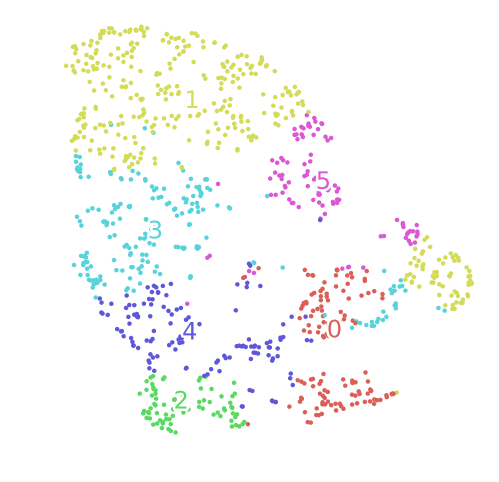

In [30]:
y = np.hstack(km_frame.cluster)
scatter(cos_proj, y, km_num_clusters)
plt.savefig('data/images/k_mean_10.png', dpi=120)

### Another clustering method

#### AffinityPropagation

In [31]:
from sklearn.cluster import AffinityPropagation

In [32]:
af = AffinityPropagation(damping=0.6, preference=-100, max_iter=5000).fit(distance_cos)

af_cluster_centers_indices = af.cluster_centers_indices_
af_num_clusters = len(af_cluster_centers_indices)

af_frame = data.copy()
af_frame['cluster'] = af.labels_.tolist()

In [33]:
print_clusters(af_frame, af_num_clusters)

Number of clusters: 15

Jokes of cluster # 0 :
++++++++++++++++++++


RikI Havent had sex in sooooooo long
RikI It's gotten to the point where i masturbate thinking of other times i masturbated.
Vorm ...,
---------------------

chaowork dont singe the wenis
faustwork yeah, nude bacon cooking is tricky
chaowork i hear thats gonna be in the next olympics
faustwork you should see how i flip it over,
---------------------

timmo make me dumplings
timmo and some grit
Fustard grits*
Fustard grit would be dirt, tim
timmo no zach im watchin my weight i only want one grit,
---------------------

@Latino-Heat when i was in school, during free periods i'd sit in the library cos i couldnt go home and i'd look up stds in encyclopedias 
@Latino-Heat cos i had rashes everywhere,
---------------------



Jokes of cluster # 1 :
++++++++++++++++++++


Sukato Once again
Sukato my firewall successfully blocked hack attempt from 192.168.0.1
Sukato Then some programs get kicked offline
Jed I know that IP ad

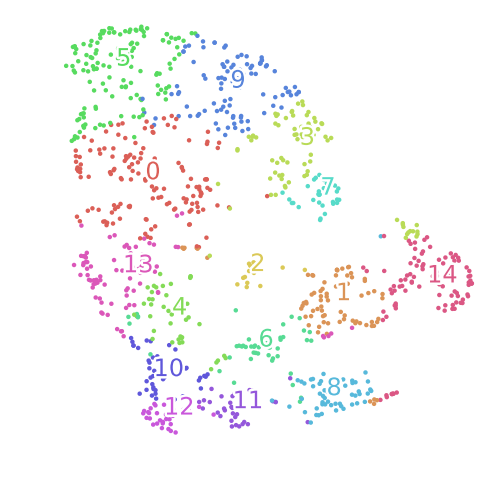

In [34]:
af_y = np.hstack(af_frame.cluster)
scatter(cos_proj, af_y, af_num_clusters)
plt.savefig('data/images/af_1.png', dpi=120)